In [5]:
import math
import gym
from enum import IntEnum
import numpy as np
from gym import error, spaces, utils
from gym.utils import seeding
import gym_minigrid
import matplotlib.pyplot as plt
# Size in pixels of a cell in the full-scale human view
CELL_PIXELS = 32

# Number of cells (width and height) in the agent view
AGENT_VIEW_SIZE = 7

# Size of the array given as an observation to the agent
OBS_ARRAY_SIZE = (AGENT_VIEW_SIZE, AGENT_VIEW_SIZE, 3)

# Map of color names to RGB values
COLORS = {
    'red': np.array([255, 0, 0]),
    'green': np.array([0, 255, 0]),
    'blue': np.array([0, 0, 255]),
    'purple': np.array([112, 39, 195]),
    'yellow': np.array([255, 255, 0]),
    'grey': np.array([100, 100, 100])
}

COLOR_NAMES = sorted(list(COLORS.keys()))

# Used to map colors to integers
COLOR_TO_IDX = {
    'red': 0,
    'green': 1,
    'blue': 2,
    'purple': 3,
    'yellow': 4,
    'grey': 5
}

IDX_TO_COLOR = dict(zip(COLOR_TO_IDX.values(), COLOR_TO_IDX.keys()))

# Map of object type to integers
OBJECT_TO_IDX = {
    'empty': 0,
    'wall': 1,
    'floor': 2,
    'door': 3,
    'locked_door': 4,
    'key': 5,
    'ball': 6,
    'box': 7,
    'goal': 8
}

IDX_TO_OBJECT = dict(zip(OBJECT_TO_IDX.values(), OBJECT_TO_IDX.keys()))

# Map of agent direction indices to vectors
DIR_TO_VEC = [
    # Pointing right (positive X)
    np.array((1, 0)),
    # Down (positive Y)
    np.array((0, 1)),
    # Pointing left (negative X)
    np.array((-1, 0)),
    # Up (negative Y)
    np.array((0, -1)),
]


class WorldObj:
    """
    Base class for grid world objects
    """

    def __init__(self, type, color):
   #     assert type in OBJECT_TO_IDX, type
    #    assert color in COLOR_TO_IDX, color
        self.type = type
        self.color = color
        self.contains = None

        # Initial position of the object
        self.init_pos = None

        # Current position of the object
        self.cur_pos = None

    def can_overlap(self):
        """Can the agent overlap with this?"""
        return False

    def can_pickup(self):
        """Can the agent pick this up?"""
        return False

    def can_contain(self):
        """Can this contain another object?"""
        return False

    def see_behind(self):
        """Can the agent see behind this object?"""
        return True

    def toggle(self, env, pos):
        """Method to trigger/toggle an action this object performs"""
        return False

    def render(self, r):
        """Draw this object with the given renderer"""
        raise NotImplementedError

    def _set_color(self, r):
        """Set the color of this object as the active drawing color"""
        c = COLORS[self.color]
        r.setLineColor(c[0], c[1], c[2])
        r.setColor(c[0], c[1], c[2])
    def encode(self):
        """Encode the a description of this object as a 3-tuple of integers"""
        return (OBJECT_TO_IDX[self.type], COLOR_TO_IDX[self.color], 0)


class Goal(WorldObj):
    def __init__(self):
        super().__init__('goal', 'green')

    def can_overlap(self):
        return True

    def render(self, r):
        self._set_color(r)
        r.drawPolygon([
            (0, CELL_PIXELS),
            (CELL_PIXELS, CELL_PIXELS),
            (CELL_PIXELS, 0),
            (0, 0)
        ])


class Floor(WorldObj):
    """
    Colored floor tile the agent can walk over
    """

    def __init__(self, color='blue'):
        super().__init__('floor', color)

    def can_overlap(self):
        return True

    def render(self, r):
        # Give the floor a pale color
        c = COLORS[self.color]
        r.setLineColor(100, 100, 100, 0)
        r.setColor(*c / 2)
        r.drawPolygon([
            (1, CELL_PIXELS),
            (CELL_PIXELS, CELL_PIXELS),
            (CELL_PIXELS, 1),
            (1, 1)
        ])


class Wall(WorldObj):
    def __init__(self, color='grey'):
        super().__init__('wall', color)

    def see_behind(self):
        return False

    def render(self, r):
        self._set_color(r)
        r.drawPolygon([
            (0, CELL_PIXELS),
            (CELL_PIXELS, CELL_PIXELS),
            (CELL_PIXELS, 0),
            (0, 0)
        ])


class Door(WorldObj):
    def __init__(self, color, is_open=False):
        super().__init__('door', color)
        self.is_open = is_open

    def can_overlap(self):
        """The agent can only walk over this cell when the door is open"""
        return self.is_open

    def see_behind(self):
        return self.is_open

    def toggle(self, env, pos):
        self.is_open = not self.is_open
        return True

    def render(self, r):
        c = COLORS[self.color]
        r.setLineColor(c[0], c[1], c[2])
        r.setColor(0, 0, 0)

        if self.is_open:
            r.drawPolygon([
                (CELL_PIXELS - 2, CELL_PIXELS),
                (CELL_PIXELS, CELL_PIXELS),
                (CELL_PIXELS, 0),
                (CELL_PIXELS - 2, 0)
            ])
            return

        r.drawPolygon([
            (0, CELL_PIXELS),
            (CELL_PIXELS, CELL_PIXELS),
            (CELL_PIXELS, 0),
            (0, 0)
        ])
        r.drawPolygon([
            (2, CELL_PIXELS - 2),
            (CELL_PIXELS - 2, CELL_PIXELS - 2),
            (CELL_PIXELS - 2, 2),
            (2, 2)
        ])
        r.drawCircle(CELL_PIXELS * 0.75, CELL_PIXELS * 0.5, 2)


class LockedDoor(WorldObj):
    def __init__(self, color, is_open=False):
        super(LockedDoor, self).__init__('locked_door', color)
        self.is_open = is_open

    def toggle(self, env, pos):
        # If the player has the right key to open the door
        if isinstance(env.carrying, Key) and env.carrying.color == self.color:
            self.is_open = True
            # The key has been used, remove it from the agent
            env.carrying = None
            return True
        return False

    def can_overlap(self):
        """The agent can only walk over this cell when the door is open"""
        return self.is_open

    def see_behind(self):
        return self.is_open

    def render(self, r):
        c = COLORS[self.color]
        r.setLineColor(c[0], c[1], c[2])
        r.setColor(c[0], c[1], c[2], 50)

        if self.is_open:
            r.drawPolygon([
                (CELL_PIXELS - 2, CELL_PIXELS),
                (CELL_PIXELS, CELL_PIXELS),
                (CELL_PIXELS, 0),
                (CELL_PIXELS - 2, 0)
            ])
            return

        r.drawPolygon([
            (0, CELL_PIXELS),
            (CELL_PIXELS, CELL_PIXELS),
            (CELL_PIXELS, 0),
            (0, 0)
        ])
        r.drawPolygon([
            (2, CELL_PIXELS - 2),
            (CELL_PIXELS - 2, CELL_PIXELS - 2),
            (CELL_PIXELS - 2, 2),
            (2, 2)
        ])
        r.drawLine(
            CELL_PIXELS * 0.55,
            CELL_PIXELS * 0.5,
            CELL_PIXELS * 0.75,
            CELL_PIXELS * 0.5
        )


class Key(WorldObj):
    def __init__(self, color='blue'):
        super(Key, self).__init__('key', color)

    def can_pickup(self):
        return True

    def render(self, r):
        self._set_color(r)

        # Vertical quad
        r.drawPolygon([
            (16, 10),
            (20, 10),
            (20, 28),
            (16, 28)
        ])

        # Teeth
        r.drawPolygon([
            (12, 19),
            (16, 19),
            (16, 21),
            (12, 21)
        ])
        r.drawPolygon([
            (12, 26),
            (16, 26),
            (16, 28),
            (12, 28)
        ])

        r.drawCircle(18, 9, 6)
        r.setLineColor(0, 0, 0)
        r.setColor(0, 0, 0)
        r.drawCircle(18, 9, 2)


class Ball(WorldObj):
    def __init__(self, color='blue'):
        super(Ball, self).__init__('ball', color)

    def can_pickup(self):
        return True

    def render(self, r):
        self._set_color(r)
        r.drawCircle(CELL_PIXELS * 0.5, CELL_PIXELS * 0.5, 10)


class Box(WorldObj):
    def __init__(self, color, contains=None):
        super(Box, self).__init__('box', color)
        self.contains = contains

    def can_pickup(self):
        return True

    def render(self, r):
        c = COLORS[self.color]
        r.setLineColor(c[0], c[1], c[2])
        r.setColor(0, 0, 0)
        r.setLineWidth(2)

        r.drawPolygon([
            (4, CELL_PIXELS - 4),
            (CELL_PIXELS - 4, CELL_PIXELS - 4),
            (CELL_PIXELS - 4, 4),
            (4, 4)
        ])

        r.drawLine(
            4,
            CELL_PIXELS / 2,
            CELL_PIXELS - 4,
            CELL_PIXELS / 2
        )

        r.setLineWidth(1)

    def toggle(self, env, pos):
        # Replace the box by its contents
        env.grid.set(*pos, self.contains)
        return True


class Grid:
    """
    Represent a grid and operations on it
    """

    def __init__(self, width, height):
        assert width >= 4
        assert height >= 4

        self.width = width
        self.height = height

        self.grid = [None] * width * height

    def __contains__(self, key):
        if isinstance(key, WorldObj):
            for e in self.grid:
                if e is key:
                    return True
        elif isinstance(key, tuple):
            for e in self.grid:
                if e is None:
                    continue
                if (e.color, e.type) == key:
                    return True
                if key[0] is None and key[1] == e.type:
                    return True
        return False

    def __eq__(self, other):
        grid1 = self.encode()
        grid2 = other.encode()
        return np.array_equal(grid2, grid1)

    def __ne__(self, other):
        return not self == other

    def copy(self):
        from copy import deepcopy
        return deepcopy(self)

    def set(self, i, j, v):
        assert i >= 0 and i < self.width
        assert j >= 0 and j < self.height
        self.grid[j * self.width + i] = v

    def get(self, i, j):
        assert i >= 0 and i < self.width
        assert j >= 0 and j < self.height
        return self.grid[j * self.width + i]

    def horz_wall(self, x, y, length=None):
        if length is None:
            length = self.width - x
        for i in range(0, length):
            self.set(x + i, y, Wall())

    def vert_wall(self, x, y, length=None):
        if length is None:
            length = self.height - y
        for j in range(0, length):
            self.set(x, y + j, Wall())

    def wall_rect(self, x, y, w, h):
        self.horz_wall(x, y, w)
        self.horz_wall(x, y + h - 1, w)
        self.vert_wall(x, y, h)
        self.vert_wall(x + w - 1, y, h)

    def rotate_left(self):
        """
        Rotate the grid to the left (counter-clockwise)
        """

        grid = Grid(self.width, self.height)

        for j in range(0, self.height):
            for i in range(0, self.width):
                v = self.get(self.width - 1 - j, i)
                grid.set(i, j, v)

        return grid

    def slice(self, topX, topY, width, height):
        """
        Get a subset of the grid
        """

        grid = Grid(width, height)

        for j in range(0, height):
            for i in range(0, width):
                x = topX + i
                y = topY + j

                if x >= 0 and x < self.width and \
                        y >= 0 and y < self.height:
                    v = self.get(x, y)
                else:
                    v = Wall()

                grid.set(i, j, v)

        return grid

    def render(self, r, tile_size):
        """
        Render this grid at a given scale
        :param r: target renderer object
        :param tile_size: tile size in pixels
        """

        assert r.width == self.width * tile_size
        assert r.height == self.height * tile_size

        # Total grid size at native scale
        widthPx = self.width * CELL_PIXELS
        heightPx = self.height * CELL_PIXELS

        r.push()

        # Internally, we draw at the "large" full-grid resolution, but we
        # use the renderer to scale back to the desired size
        r.scale(tile_size / CELL_PIXELS, tile_size / CELL_PIXELS)

        # Draw the background of the in-world cells black
        r.fillRect(
            0,
            0,
            widthPx,
            heightPx,
            0, 0, 0
        )

        # Draw grid lines
        r.setLineColor(100, 100, 100)
        for rowIdx in range(0, self.height):
            y = CELL_PIXELS * rowIdx
            r.drawLine(0, y, widthPx, y)
        for colIdx in range(0, self.width):
            x = CELL_PIXELS * colIdx
            r.drawLine(x, 0, x, heightPx)

        # Render the grid
        for j in range(0, self.height):
            for i in range(0, self.width):
                cell = self.get(i, j)
                if cell == None:
                    continue
                r.push()
                r.translate(i * CELL_PIXELS, j * CELL_PIXELS)
                cell.render(r)
                r.pop()

        r.pop()

    def encode(self):
        """
        Produce a compact numpy encoding of the grid
        """

        codeSize = self.width * self.height * 3

        array = np.zeros(shape=(self.width, self.height, 3), dtype='uint8')

        for j in range(0, self.height):
            for i in range(0, self.width):

                v = self.get(i, j)

                if v == None:
                    continue

                array[i, j, 0] = OBJECT_TO_IDX[v.type]
                array[i, j, 1] = COLOR_TO_IDX[v.color]

                if hasattr(v, 'is_open') and v.is_open:
                    array[i, j, 2] = 1

        return array

    def decode(array):
        """
        Decode an array grid encoding back into a grid
        """

        width = array.shape[0]
        height = array.shape[1]
        assert array.shape[2] == 3

        grid = Grid(width, height)

        for j in range(0, height):
            for i in range(0, width):

                typeIdx = array[i, j, 0]
                colorIdx = array[i, j, 1]
                openIdx = array[i, j, 2]

                if typeIdx == 0:
                    continue

                objType = IDX_TO_OBJECT[typeIdx]
                color = IDX_TO_COLOR[colorIdx]
                is_open = True if openIdx == 1 else 0

                if objType == 'wall':
                    v = Wall(color)
                elif objType == 'floor':
                    v = Floor(color)
                elif objType == 'ball':
                    v = Ball(color)
                elif objType == 'key':
                    v = Key(color)
                elif objType == 'box':
                    v = Box(color)
                elif objType == 'door':
                    v = Door(color, is_open)
                elif objType == 'locked_door':
                    v = LockedDoor(color, is_open)
                elif objType == 'goal':
                    v = Goal()
                else:
                    assert False, "unknown obj type in decode '%s'" % objType

                grid.set(i, j, v)

        return grid

    def process_vis(grid, agent_pos):
        mask = np.zeros(shape=(grid.width, grid.height), dtype=np.bool)

        mask[agent_pos[0], agent_pos[1]] = True

        for j in reversed(range(1, grid.height)):
            for i in range(0, grid.width - 1):
                if not mask[i, j]:
                    continue

                cell = grid.get(i, j)
                if cell and not cell.see_behind():
                    continue

                mask[i + 1, j] = True
                mask[i + 1, j - 1] = True
                mask[i, j - 1] = True

            for i in reversed(range(1, grid.width)):
                if not mask[i, j]:
                    continue

                cell = grid.get(i, j)
                if cell and not cell.see_behind():
                    continue

                mask[i - 1, j - 1] = True
                mask[i - 1, j] = True
                mask[i, j - 1] = True

        for j in range(0, grid.height):
            for i in range(0, grid.width):
                if not mask[i, j]:
                    grid.set(i, j, None)

        return mask


class MiniGridEnv(gym.Env):
    """
    2D grid world game environment
    """

    metadata = {
        'render.modes': ['human', 'rgb_array', 'pixmap'],
        'video.frames_per_second': 10
    }

    # Enumeration of possible actions
    class Actions(IntEnum):
        # Turn left, turn right, move forward
        left = 0
        right = 1
        forward = 2

        # Pick up an object
        pickup = 3
        # Drop an object
        drop = 4
        # Toggle/activate an object
        toggle = 5

        # Done completing task
        done = 6

    def __init__(
            self,
            grid_size=16,
            max_steps=100,
            see_through_walls=False,
            seed=1337
    ):
        # Action enumeration for this environment
        self.actions = MiniGridEnv.Actions

        # Actions are discrete integer values
        self.action_space = spaces.Discrete(len(self.actions))

        # Observations are dictionaries containing an
        # encoding of the grid and a textual 'mission' string
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=OBS_ARRAY_SIZE,
            dtype='uint8'
        )
        self.observation_space = spaces.Dict({
            'image': self.observation_space
        })

        # Range of possible rewards
        self.reward_range = (0, 1)

        # Renderer object used to render the whole grid (full-scale)
        self.grid_render = None

        # Renderer used to render observations (small-scale agent view)
        self.obs_render = None

        # Environment configuration
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.see_through_walls = see_through_walls

        # Starting position and direction for the agent
        self.start_pos = None
        self.start_dir = None

        # Initialize the RNG
        self.seed(seed=seed)
        self.set_reward_multiplier(0.9)

        # Initialize the state
        self.reset()

    def reset(self):
        # Generate a new random grid at the start of each episode
        # To keep the same grid for each episode, call env.seed() with
        # the same seed before calling env.reset()
        self._gen_grid(self.grid_size, self.grid_size)

        # These fields should be defined by _gen_grid
        assert self.start_pos is not None
        assert self.start_dir is not None

        # Check that the agent doesn't overlap with an object
        start_cell = self.grid.get(*self.start_pos)
        assert start_cell is None or start_cell.can_overlap()

        # Place the agent in the starting position and direction
        self.agent_pos = self.start_pos
        self.agent_dir = self.start_dir

        # Item picked up, being carried, initially nothing
        self.carrying = None

        # Step count since episode start
        self.step_count = 0

        # Return first observation
        obs = self.gen_obs()
        return obs

    def set_wall_id(self, fixed_wall_id):
        self.fixed_wall_id = fixed_wall_id

    def seed(self, seed=1337):
        # Seed the random number generator
        self.np_random, _ = seeding.np_random(seed)
        # Set not to use fixed wall
        self.fixed_wall_id = -1
        return [seed]

    def set_reward_multiplier(self, reward_multiplier):
        assert reward_multiplier > 0 and reward_multiplier <= 1
        self.reward_multiplier = reward_multiplier

    @property
    def steps_remaining(self):
        return self.max_steps - self.step_count

    def __str__(self):
        """
        Produce a pretty string of the environment's grid along with the agent.
        The agent is represented by `⏩`. A grid pixel is represented by 2-character
        string, the first one for the object and the second one for the color.
        """

        from copy import deepcopy

        def rotate_left(array):
            new_array = deepcopy(array)
            for i in range(len(array)):
                for j in range(len(array[0])):
                    new_array[j][len(array[0]) - 1 - i] = array[i][j]
            return new_array

        def vertically_symmetrize(array):
            new_array = deepcopy(array)
            for i in range(len(array)):
                for j in range(len(array[0])):
                    new_array[i][len(array[0]) - 1 - j] = array[i][j]
            return new_array

        # Map of object id to short string
        OBJECT_IDX_TO_IDS = {
            0: ' ',
            1: 'W',
            2: 'D',
            3: 'L',
            4: 'K',
            5: 'B',
            6: 'X',
            7: 'G'
        }

        # Short string for opened door
        OPENDED_DOOR_IDS = '_'

        # Map of color id to short string
        COLOR_IDX_TO_IDS = {
            0: 'R',
            1: 'G',
            2: 'B',
            3: 'P',
            4: 'Y',
            5: 'E'
        }

        # Map agent's direction to short string
        AGENT_DIR_TO_IDS = {
            0: '⏩ ',
            1: '⏬ ',
            2: '⏪ ',
            3: '⏫ '
        }

        array = self.grid.encode()

        array = rotate_left(array)
        array = vertically_symmetrize(array)

        new_array = []

        for line in array:
            new_line = []

            for pixel in line:
                # If the door is opened
                if pixel[0] in [2, 3] and pixel[2] == 1:
                    object_ids = OPENDED_DOOR_IDS
                else:
                    object_ids = OBJECT_IDX_TO_IDS[pixel[0]]

                # If no object
                if pixel[0] == 0:
                    color_ids = ' '
                else:
                    color_ids = COLOR_IDX_TO_IDS[pixel[1]]

                new_line.append(object_ids + color_ids)

            new_array.append(new_line)

        # Add the agent
        new_array[self.agent_pos[1]][self.agent_pos[0]] = AGENT_DIR_TO_IDS[self.agent_dir]

        return "\n".join([" ".join(line) for line in new_array])

    def _gen_grid(self, width, height):
        assert False, "_gen_grid needs to be implemented by each environment"

    def _reward(self):
        """
        Compute the reward to be given upon success
        self.reward_multiplier default 0.9
        """

        return 1 - self.reward_multiplier * (self.step_count / self.max_steps)

    def _rand_int(self, low, high):
        """
        Generate random integer in [low,high[
        """

        return self.np_random.randint(low, high)

    def _rand_float(self, low, high):
        """
        Generate random float in [low,high[
        """

        return self.np_random.uniform(low, high)

    def _rand_bool(self):
        """
        Generate random boolean value
        """

        return (self.np_random.randint(0, 2) == 0)

    def _rand_elem(self, iterable):
        """
        Pick a random element in a list
        """

        lst = list(iterable)
        idx = self._rand_int(0, len(lst))
        return lst[idx]

    def _rand_subset(self, iterable, num_elems):
        """
        Sample a random subset of distinct elements of a list
        """

        lst = list(iterable)
        assert num_elems <= len(lst)

        out = []

        while len(out) < num_elems:
            elem = self._rand_elem(lst)
            lst.remove(elem)
            out.append(elem)

        return out

    def _rand_color(self):
        """
        Generate a random color name (string)
        """

        return self._rand_elem(COLOR_NAMES)

    def _rand_pos(self, xLow, xHigh, yLow, yHigh):
        """
        Generate a random (x,y) position tuple
        """

        return (
            self.np_random.randint(xLow, xHigh),
            self.np_random.randint(yLow, yHigh)
        )

    def place_obj(self,
                  obj,
                  top=None,
                  size=None,
                  reject_fn=None,
                  max_tries=math.inf
                  ):
        """
        Place an object at an empty position in the grid
        :param top: top-left position of the rectangle where to place
        :param size: size of the rectangle where to place
        :param reject_fn: function to filter out potential positions
        """

        if top is None:
            top = (0, 0)

        if size is None:
            size = (self.grid.width, self.grid.height)

        num_tries = 0

        while True:
            # This is to handle with rare cases where rejection sampling
            # gets stuck in an infinite loop
            if num_tries > max_tries:
                raise RecursionError('rejection sampling failed in place_obj')

            num_tries += 1

            pos = np.array((
                self._rand_int(top[0], top[0] + size[0]),
                self._rand_int(top[1], top[1] + size[1])
            ))

            # Don't place the object on top of another object
            if self.grid.get(*pos) != None:
                continue

            # Don't place the object where the agent is
            if np.array_equal(pos, self.start_pos):
                continue

            # Check if there is a filtering criterion
            if reject_fn and reject_fn(self, pos):
                continue

            break

        self.grid.set(*pos, obj)

        if obj is not None:
            obj.init_pos = pos
            obj.cur_pos = pos

        return pos

    def place_agent(
            self,
            top=None,
            size=None,
            rand_dir=True,
            max_tries=math.inf
    ):
        """
        Set the agent's starting point at an empty position in the grid
        """

        self.start_pos = None
        pos = self.place_obj(None, top, size, max_tries=max_tries)
        self.start_pos = pos

        if rand_dir:
            self.start_dir = self._rand_int(0, 4)

        return pos

    @property
    def dir_vec(self):
        """
        Get the direction vector for the agent, pointing in the direction
        of forward movement.
        """

        assert self.agent_dir >= 0 and self.agent_dir < 4
        return DIR_TO_VEC[self.agent_dir]

    @property
    def right_vec(self):
        """
        Get the vector pointing to the right of the agent.
        """

        dx, dy = self.dir_vec
        return np.array((-dy, dx))

    @property
    def front_pos(self):
        """
        Get the position of the cell that is right in front of the agent
        """

        return self.agent_pos + self.dir_vec

    def get_view_coords(self, i, j):
        """
        Translate and rotate absolute grid coordinates (i, j) into the
        agent's partially observable view (sub-grid). Note that the resulting
        coordinates may be negative or outside of the agent's view size.
        """

        ax, ay = self.agent_pos
        dx, dy = self.dir_vec
        rx, ry = self.right_vec

        # Compute the absolute coordinates of the top-left view corner
        sz = AGENT_VIEW_SIZE
        hs = AGENT_VIEW_SIZE // 2
        tx = ax + (dx * (sz - 1)) - (rx * hs)
        ty = ay + (dy * (sz - 1)) - (ry * hs)

        lx = i - tx
        ly = j - ty

        # Project the coordinates of the object relative to the top-left
        # corner onto the agent's own coordinate system
        vx = (rx * lx + ry * ly)
        vy = -(dx * lx + dy * ly)

        return vx, vy

    def get_view_exts(self):
        """
        Get the extents of the square set of tiles visible to the agent
        Note: the bottom extent indices are not included in the set
        """

        # Facing right
        if self.agent_dir == 0:
            topX = self.agent_pos[0]
            topY = self.agent_pos[1] - AGENT_VIEW_SIZE // 2
        # Facing down
        elif self.agent_dir == 1:
            topX = self.agent_pos[0] - AGENT_VIEW_SIZE // 2
            topY = self.agent_pos[1]
        # Facing left
        elif self.agent_dir == 2:
            topX = self.agent_pos[0] - AGENT_VIEW_SIZE + 1
            topY = self.agent_pos[1] - AGENT_VIEW_SIZE // 2
        # Facing up
        elif self.agent_dir == 3:
            topX = self.agent_pos[0] - AGENT_VIEW_SIZE // 2
            topY = self.agent_pos[1] - AGENT_VIEW_SIZE + 1
        else:
            assert False, "invalid agent direction"

        botX = topX + AGENT_VIEW_SIZE
        botY = topY + AGENT_VIEW_SIZE

        return (topX, topY, botX, botY)

    def agent_sees(self, x, y):
        """
        Check if a grid position is visible to the agent
        """

        vx, vy = self.get_view_coords(x, y)

        if vx < 0 or vy < 0 or vx >= AGENT_VIEW_SIZE or vy >= AGENT_VIEW_SIZE:
            return False

        obs = self.gen_obs()
        obs_grid = Grid.decode(obs['image'])
        obs_cell = obs_grid.get(vx, vy)
        world_cell = self.grid.get(x, y)

        return obs_cell is not None and obs_cell.type == world_cell.type

    def step(self, action):
        self.step_count += 1

        reward = 0
        done = False

        # Get the position in front of the agent
        fwd_pos = self.front_pos

        # Get the contents of the cell in front of the agent
        fwd_cell = self.grid.get(*fwd_pos)

        # Rotate left
        if action == self.actions.left:
            self.agent_dir -= 1
            if self.agent_dir < 0:
                self.agent_dir += 4

        # Rotate right
        elif action == self.actions.right:
            self.agent_dir = (self.agent_dir + 1) % 4

        # Move forward
        elif action == self.actions.forward:
            if fwd_cell == None or fwd_cell.can_overlap():
                self.agent_pos = fwd_pos
            if fwd_cell != None and fwd_cell.type == 'goal':
                done = True
                reward = self._reward()

        # Pick up an object
        elif action == self.actions.pickup:
            if fwd_cell and fwd_cell.can_pickup():
                if self.carrying is None:
                    self.carrying = fwd_cell
                    self.carrying.cur_pos = np.array([-1, -1])
                    self.grid.set(*fwd_pos, None)

        # Drop an object
        elif action == self.actions.drop:
            if not fwd_cell and self.carrying:
                self.grid.set(*fwd_pos, self.carrying)
                self.carrying.cur_pos = fwd_pos
                self.carrying = None

        # Toggle/activate an object
        elif action == self.actions.toggle:
            if fwd_cell:
                fwd_cell.toggle(self, fwd_pos)

        # Done action (not used by default)
        elif action == self.actions.done:
            pass

        else:
            assert False, "unknown action"

        if self.step_count >= self.max_steps:
            done = True

        obs = self.gen_obs()

        return obs, reward, done, {}

    def gen_obs_grid(self):
        """
        Generate the sub-grid observed by the agent.
        This method also outputs a visibility mask telling us which grid
        cells the agent can actually see.
        """

        topX, topY, botX, botY = self.get_view_exts()

        grid = self.grid.slice(topX, topY, AGENT_VIEW_SIZE, AGENT_VIEW_SIZE)

        for i in range(self.agent_dir + 1):
            grid = grid.rotate_left()

        # Process occluders and visibility
        # Note that this incurs some performance cost
        if not self.see_through_walls:
            vis_mask = grid.process_vis(agent_pos=(AGENT_VIEW_SIZE // 2, AGENT_VIEW_SIZE - 1))
        else:
            vis_mask = np.ones(shape=(grid.width, grid.height), dtype=np.bool)

        # Make it so the agent sees what it's carrying
        # We do this by placing the carried object at the agent's position
        # in the agent's partially observable view
        agent_pos = grid.width // 2, grid.height - 1
        if self.carrying:
            grid.set(*agent_pos, self.carrying)
        else:
            grid.set(*agent_pos, None)

        return grid, vis_mask

    def gen_obs(self):
        """
        Generate the agent's view (partially observable, low-resolution encoding)
        """

        grid, vis_mask = self.gen_obs_grid()

        # Encode the partially observable view into a numpy array
        image = grid.encode()

        assert hasattr(self, 'mission'), "environments must define a textual mission string"

        # Observations are dictionaries containing:
        # - an image (partially observable view of the environment)
        # - the agent's direction/orientation (acting as a compass)
        # - a textual mission string (instructions for the agent)
        obs = {
            'image': image,
            'direction': self.agent_dir,
            'mission': self.mission
        }

        return obs

    def get_obs_render(self, obs, tile_pixels=CELL_PIXELS // 2):
        """
        Render an agent observation for visualization
        """

        if self.obs_render == None:
            from gym_minigrid.rendering import Renderer
            self.obs_render = Renderer(
                AGENT_VIEW_SIZE * tile_pixels,
                AGENT_VIEW_SIZE * tile_pixels
            )

        r = self.obs_render

        r.beginFrame()

        grid = Grid.decode(obs)

        # Render the whole grid
        grid.render(r, tile_pixels)

        # Draw the agent
        ratio = tile_pixels / CELL_PIXELS
        r.push()
        r.scale(ratio, ratio)
        r.translate(
            CELL_PIXELS * (0.5 + AGENT_VIEW_SIZE // 2),
            CELL_PIXELS * (AGENT_VIEW_SIZE - 0.5)
        )
        r.rotate(3 * 90)
        r.setLineColor(255, 0, 0)
        r.setColor(255, 0, 0)
        r.drawPolygon([
            (-12, 10),
            (12, 0),
            (-12, -10)
        ])
        r.pop()

        r.endFrame()

        return r.getPixmap()

    def render(self, mode='human', close=False):
        """
        Render the whole-grid human view
        """

        if close:
            if self.grid_render:
                self.grid_render.close()
            return

        if self.grid_render is None:
            from gym_minigrid.rendering import Renderer
            self.grid_render = Renderer(
                self.grid_size * CELL_PIXELS,
                self.grid_size * CELL_PIXELS,
                True if mode == 'human' else False
            )

        r = self.grid_render

        r.beginFrame()

        # Render the whole grid
        self.grid.render(r, CELL_PIXELS)

        # Draw the agent
        r.push()
        r.translate(
            CELL_PIXELS * (self.agent_pos[0] + 0.5),
            CELL_PIXELS * (self.agent_pos[1] + 0.5)
        )
        r.rotate(self.agent_dir * 90)
        r.setLineColor(255, 0, 0)
        r.setColor(255, 0, 0)
        r.drawPolygon([
            (-12, 10),
            (12, 0),
            (-12, -10)
        ])
        r.pop()

        # Compute which cells are visible to the agent
        _, vis_mask = self.gen_obs_grid()

        # Compute the absolute coordinates of the bottom-left corner
        # of the agent's view area
        f_vec = self.dir_vec
        r_vec = self.right_vec
        top_left = self.agent_pos + f_vec * (AGENT_VIEW_SIZE - 1) - r_vec * (AGENT_VIEW_SIZE // 2)

        # For each cell in the visibility mask
        for vis_j in range(0, AGENT_VIEW_SIZE):
            for vis_i in range(0, AGENT_VIEW_SIZE):
                # If this cell is not visible, don't highlight it
                if not vis_mask[vis_i, vis_j]:
                    continue

                # Compute the world coordinates of this cell
                abs_i, abs_j = top_left - (f_vec * vis_j) + (r_vec * vis_i)

                # Highlight the cell
                r.fillRect(
                    abs_i * CELL_PIXELS,
                    abs_j * CELL_PIXELS,
                    CELL_PIXELS,
                    CELL_PIXELS,
                    255, 255, 255, 75
                )

        r.endFrame()

        if mode == 'rgb_array':
            return r.getArray()
        elif mode == 'pixmap':
            return r.getPixmap()

        return r


In [6]:
from gym_minigrid.register import register

class DoorKeyEnv(MiniGridEnv):
    """
    Environment with a door and key, sparse reward
    """

    def __init__(self, size=8):
        super().__init__(
            grid_size=size,
            max_steps=10*size*size
        )

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Place a goal in the bottom-right corner
        self.grid.set(width - 2, height - 2, Goal())

        # Create a vertical splitting wall
        splitIdx = self._rand_int(2, width-2)
        self.grid.vert_wall(splitIdx, 0)

        # Place the agent at a random position and orientation
        # on the left side of the splitting wall
        self.start_pos = self.place_agent(size=(splitIdx, height))

        # Place a door in the wall
        doorIdx = self._rand_int(1, width-2)
        self.grid.set(splitIdx, doorIdx, LockedDoor('yellow'))

        # Place a yellow key on the left side
        self.place_obj(
            obj=Key('yellow'),
            top=(0, 0),
            size=(splitIdx, height)
        )

        self.mission = "use the key to open the door and then get to the goal"

class DoorKeyEnv5x5(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=5)

class DoorKeyEnv6x6(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=6)

class DoorKeyEnv10x10(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=10)

class DoorKeyEnv12x12(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=12)

class DoorKeyEnv14x14(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=14)

class DoorKeyEnv16x16(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=16)


class DoorKeyEnv5x5(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=5)


class DoorKeyEnv6x6(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=6)


class DoorKeyEnv10x10(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=10)


class DoorKeyEnv12x12(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=12)


class DoorKeyEnv14x14(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=14)


class DoorKeyEnv16x16(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=16)
def preprocess_images(images, device=None):
    # Bug of Pytorch: very slow if not first converted to numpy array
    images = np.array(images)
    return torch.tensor(images, device=device, dtype=torch.float)

def get_obss_preprocessor():
    obs_space = {"image": [7,7,3]}

    def preprocess_obss(obss, device=None):
        return torch_ac.DictList({
            "image": preprocess_images([obs["image"] for obs in obss], device=device)
        })

    return obs_space, preprocess_obss

In [9]:
import argparse
import time
import datetime
import torch
import torch_ac
import tensorboardX
import sys
sys.path.insert(0,'/root/server/Semantic-Loss/complex_constraints/curriculum learning/automatic-curriculum/')
import utils
import auto_curri as ac
from model import ACModel
import numpy as np
class parser:
    def __init__(self):
        self.env=None#'MiniGrid-Unlock-v0'#'MiniGrid-BlockedUnlockPickup-v0'
        self.curriculum='empty'
        self.model=None
        self.seed=1
        self.log_interval=1
        self.save_interval=10
        self.procs=1
        self.frames=10**7
        self.epochs=4
        self.batch_size=256
        self.frames_per_proc=128
        self.discount=0.99
        self.lr=0.001
        self.gae_lambda=0.95
        self.entropy_coef=0.01
        self.value_loss_coef=0.5
        self.max_grad_norm=0.5
        self.adam_eps=1e-8
        self.clip_eps=0.2
        self.lpe="Linreg"
        self.lpe_alpha=0.1
        self.lpe_K=10
        self.acp="MR"
        self.acp_MR_K=10
        self.acp_MR_power=6
        self.acp_MR_pot_prop=0.5
        self.acp_MR_att_pred=0.2
        self.acp_MR_att_succ=0.05
        self.a2d="Prop"
        self.a2d_eps=0.1
        self.a2d_tau=4e-4

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import torch_ac


# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

device = torch.device("cuda")
class ACModel(nn.Module, torch_ac.ACModel):
    def __init__(self, obs_space, action_space):
        super().__init__()

        # Define image embedding
        self.image_embedding_size = 64
        self.image_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(2, 2)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(2, 2)),
            nn.ReLU(),
        )

        # Define actor's model
        self.actor = nn.Sequential(
            nn.Linear(16, 64),
            nn.Tanh(),
            nn.Linear(64, action_space.n)
        )

        # Define critic's model
        self.critic = nn.Sequential(
            nn.Linear(16, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        # Initialize parameters correctly
        self.apply(init_params)

    def forward(self, obs):
        x = obs.image.transpose(1, 3).transpose(2, 3).to(device)
        x = self.image_conv(x)
        x = x.reshape(x.shape[0], -1)
        
        embedding = x
        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))
        
        x = self.critic(embedding)
        value = x.squeeze(1)

        return dist, value

In [ ]:
tmp=algo4.acmodel.state_dict()
for j in algo.acmodel.state_dict().keys():
    tmp[j]=algo.acmodel.state_dict()[j]*penv_head4.dist[1]+algo2.acmodel.state_dict()[j]*penv_head4.dist[0]+algo3.acmodel.state_dict()[j]*penv_head4.dist[2]
torch.save(tmp, 'net_params_algo4.pkl')
algo4.acmodel.load_state_dict(torch.load('net_params_algo4.pkl'))

In [ ]:
#np.save('rewardsGNN.npy',rewards)
#np.save('rewards2GNN.npy',rewards2)
#np.save('rewards3GNN.npy',rewards3)

In [ ]:
import torch.optim as optim
class g2apara:
    def __init__(self):
        self.rnn_hidden_dim=16
        self.n_agents=2
        self.attention_dim=15
        self.cuda=True
        self.n_actions=7
        self.hard=True
args4=g2apara()
g2a=G2ANet(2,args4)
g2a.to(device)
optimizer = optim.SGD(g2a.parameters(), lr=1e-2, momentum=0.5)
hids=torch.from_numpy(np.random.random([2,16])).float().to(device)

envs=[gym_minigrid.envs.EmptyEnv(),gym_minigrid.envs.EmptyEnv16x16()]
env=gym_minigrid.envs.EmptyEnv()
obs_space, preprocess_obss=get_obss_preprocessor()
envs2=[DoorKeyEnv(),DoorKeyEnv16x16()]
env2=DoorKeyEnv16x16()
obs_space2, preprocess_obss2=get_obss_preprocessor()
#obs=envs[-1].reset()
#obs['image']=np.zeros([7,7,3])
#acmodel(preprocess_obss([obs]))[0].sample()
visualise=True
steps=[]
rewards=[]
avgrewards=[]
steps2=[]
rewards2=[]
avgrewards2=[]
for i in range(1000000):
    print(i)
    exps, logs1 = algo.collect_experiences()
    logs2 = algo.update_parameters(exps)
    logs = {**logs1, **logs2}
    exps2, logs1_2 = algo2.collect_experiences()
    logs2_2 = algo2.update_parameters(exps2)
    logs_2 = {**logs1_2, **logs2_2}
    if args.curriculum is not None:
        penv_head.update_dist()
    if args2.curriculum is not None:
        penv_head2.update_dist()
 #   print(i,logs['return_per_episode'],penv_head.dist)
  #  print(i,logs_2['return_per_episode'],penv_head2.dist)
    if i%50==0:
        observations = envs[-1].reset()
        rewardcnt=0
        observations2 = envs2[-1].reset()
        rewardcnt2=0
        for t in range(10000):
            if i>0:
                a=g2a.forward([observations,observations2],torch.tensor([[avgrewards[-1],np.array(rewards).std()],[avgrewards2[-1],np.array(rewards).std()]]).float().to(device),hids)
            else:
                a=g2a.forward([observations,observations2],torch.tensor([[0.,1.],[0.,1.]]).to(device),hids.to(device))
                
            hids=a[1].detach()
            action = Categorical(logits=0.9*algo.acmodel(preprocess_obss([observations]))[0].probs[0]+0.1*Categorical(logits=F.log_softmax(a[0][0], dim=0)).probs).sample()

            # Step (this will plot if visualise is True)
            observations,reward, done, _ = envs[-1].step(action)
            rewardcnt+=reward
            #print(t,done,action,reward)
            #print("[{}] reward={} done={} \n".format(t, reward, done))

            if reward:
                #rewarding_frame = observations['image'].copy()
                #rewarding_frame[:40] *= np.array([0, 1, 0])
                print("[{}] Got a rewaaaard! {:.1f}".format(t, reward))
            elif done:
                print("[{}] Finished with nothing... Reset".format(t))
                print(rewardcnt)
                break
        for t2 in range(10000):
            if i>0:
                a=g2a.forward([observations,observations2],torch.tensor([[avgrewards[-1],np.array(rewards).std()],[avgrewards2[-1],np.array(rewards).std()]]).float().to(device),hids)
            else:
                a=g2a.forward([observations,observations2],torch.tensor([[0.,1.],[0.,1.]]).to(device),hids)
                
            hids=a[1].detach()
            action2 = Categorical(logits=0.9*algo2.acmodel(preprocess_obss([observations2]))[0].probs[0]+0.1*Categorical(logits=F.log_softmax(a[0][1], dim=0)).probs).sample()

            # Step (this will plot if visualise is True)
            observations2,reward2, done2, _ = envs2[-1].step(action2)
            rewardcnt2+=reward2
            #print(t,done,action,reward)
            #print("[{}] reward={} done={} \n".format(t, reward, done))

            if reward2:
                #rewarding_frame = observations['image'].copy()
                #rewarding_frame[:40] *= np.array([0, 1, 0])
                print("[{}] Got a rewaaaard! {:.1f}".format(t, reward2))
            elif done2:
                print("[{}] Finished with nothing... Reset".format(t2))
                print(rewardcnt2)
                break                
        optimizer.zero_grad()     #等效netD.zero_grad()
        loss=torch.tensor(-rewardcnt-rewardcnt2+0.0, requires_grad=True)
        #loss=loss
        loss.backward()#(retain_graph=True)  
        optimizer.step()   # update parameters
        steps.append(t)
        rewards.append(rewardcnt)
        avgrewards.append(rewardcnt/t)  
        steps2.append(t2)
        rewards2.append(rewardcnt2)
        avgrewards2.append(rewardcnt2/t2)
        np.save('rewardsGNN.npy',rewards)
        np.save('rewards2GNN.npy',rewards2)
    #https://github.com/Feryal/craft-env/blob/master/envs[-1].py        

In [ ]:
import matplotlib.pyplot as plt
plt.plot(avgrewards2)

In [ ]:
import torch.optim as optim
class g2apara:
    def __init__(self):
        self.rnn_hidden_dim=3
        self.n_agents=2
        self.attention_dim=15
        self.cuda=False
        self.n_actions=7
        self.hard=True
args3=g2apara()
g2a=G2ANet(args3)
optimizer = optim.SGD(g2a.parameters(), lr=1e-2, momentum=0.5)
dir(g2a)

In [ ]:
#b=a[1]
a=g2a.forward([observations,observations2],torch.tensor([[avgrewards[-1]],[avgrewards2[-1]]]),hids)
hids=a[1].detach()
loss=sum(sum(a[0]))
print(a)
optimizer.zero_grad()     #等效netD.zero_grad()
loss.backward()#(retain_graph=True)  
optimizer.step()   # update parameters

In [ ]:
envs=[gym_minigrid.envs.EmptyEnv(),gym_minigrid.envs.EmptyEnv16x16()]
env=gym_minigrid.envs.EmptyEnv(),gym_minigrid.envs.EmptyEnv16x16()
obs_space, preprocess_obss=get_obss_preprocessor()
#obs=envs[-1].reset()
#obs['image']=np.zeros([7,7,3])
#acmodel(preprocess_obss([obs]))[0].sample()
visualise=True
steps=[]
rewards=[]
avgrewards=[]
for epc in range(10000):
    observations = envs[-1].reset()
    rewardcnt=0
    for t in range(10000):
        action = algo.acmodel(preprocess_obss([observations]))[0].sample()

        # Step (this will plot if visualise is True)
        observations,reward, done, _ = envs[-1].step(action)
        rewardcnt+=reward
        #print(t,done,action,reward)
        #print("[{}] reward={} done={} \n".format(t, reward, done))

        if reward:
            #rewarding_frame = observations['image'].copy()
            #rewarding_frame[:40] *= np.array([0, 1, 0])
            print("[{}] Got a rewaaaard! {:.1f}".format(t, reward))
        elif done:
            print("[{}] Finished with nothing... Reset".format(t))
            print(rewardcnt)
            break
    steps.append(t)
    rewards.append(rewardcnt)
    avgrewards.append(rewardcnt/t)
#https://github.com/Feryal/craft-env/blob/master/envs[-1].py

In [ ]:
{
    "nodes": {
        "f": {"id": "MiniGrid-Fetch-8x8-N3-v0", "min": 0, "max": 0.5},
        "e": {"id": "MiniGrid-Empty-16x16-v0", "min": 0, "max": 0.5},
        "d": {"id": "MiniGrid-DoorKey-16x16-v0", "min": 0, "max": 0.5}
    },
    "edges": [
        ["f", "e"],
        ["e", "d"]
    ]
}

In [ ]:
{
    "nodes": {
        "5": {"id": "MiniGrid-DoorKey-5x5-v0", "min": 0, "max": 0.5},
        "6": {"id": "MiniGrid-DoorKey-6x6-v0", "min": 0, "max": 0.5},
        "8": {"id": "MiniGrid-DoorKey-8x8-v0", "min": 0, "max": 0.5},
        "10": {"id": "MiniGrid-DoorKey-10x10-v0", "min": 0, "max": 0.5},
        "12": {"id": "MiniGrid-DoorKey-12x12-v0", "min": 0, "max": 0.5},
        "14": {"id": "MiniGrid-DoorKey-14x14-v0", "min": 0, "max": 0.5},
        "16": {"id": "MiniGrid-DoorKey-16x16-v0", "min": 0, "max": 0.5}
    },
    "edges": [
        ["5", "6"],
        ["6", "8"],
        ["8", "10"],
        ["10", "12"],
        ["12", "14"],
        ["14", "16"]
    ]
}

In [ ]:
[gym_minigrid.envs.EmptyEnv5x5(),gym_minigrid.envs.EmptyRandomEnv5x5(),gym_minigrid.envs.EmptyEnv6x6(),gym_minigrid.envs.EmptyRandomEnv6x6(),gym_minigrid.envs.EmptyEnv(),gym_minigrid.envs.EmptyEnv16x16()]
{
    "nodes": {
        "5": {"id": "MiniGrid-Empty-5x5-v0", "min": 0, "max": 0.5},
        "r5": {"id": "MiniGrid-Empty-Random-5x5-v0", "min": 0, "max": 0.5},
        "6": {"id": "MiniGrid-Empty-6x6-v0", "min": 0, "max": 0.5},
        "r6": {"id": "MiniGrid-Empty-Random-6x6-v0", "min": 0, "max": 0.5},
        "8": {"id": "MiniGrid-Empty-8x8-v0", "min": 0, "max": 0.5},
        "16": {"id": "MiniGrid-Empty-16x16-v0", "min": 0, "max": 0.5}
    },
    "edges": [
        ["5", "r5"],
        ["r5", "6"],
        ["6", "r6"],
        ["r6", "8"],
        ["8", "16"]
    ]
}

In [ ]:
[gym_minigrid.envs.FetchEnv5x5N2(),gym_minigrid.envs.FetchEnv6x6N2(),gym_minigrid.envs.FetchEnv()]
{
    "nodes": {
        "5": {"id": "MiniGrid-Fetch-5x5-N2-v0", "min": 0, "max": 0.5},
        "6": {"id": "MiniGrid-Fetch-6x6-N2-v0", "min": 0, "max": 0.5},
        "8": {"id": "MiniGrid-Fetch-8x8-N3-v0", "min": 0, "max": 0.5}
    },
    "edges": [
        ["5", "6"],
        ["6", "8"]
    ]
}

In [ ]:
[gym_minigrid.envs.MultiRoomEnvN2S4(),gym_minigrid.envs.MultiRoomEnvN4S5(),gym_minigrid.envs.MultiRoomEnvN6(),gym_minigrid.envs.MultiRoomEnv()]
{
    "nodes": {
        "2": {"id": "MiniGrid-MultiRoom-N2-S4-v0", "min": 0, "max": 0.5},
        "4": {"id": "MiniGrid-MultiRoom-N4-S5-v0", "min": 0, "max": 0.5},
        "6": {"id": "MiniGrid-MultiRoom-N6-v0", "min": 0, "max": 0.5},
        "8": {"id": "MiniGrid-MultiRoom-N8-v0", "min": 0, "max": 0.5}
    },
    "edges": [
        ["2", "4"],
        ["4", "6"],
        ["6", "8"]
    ]
}

In [ ]:
import networkx as nx
import os
import json

import utils


def get_curriculum(curriculum_id):
    curriculum_fname = os.path.join("/root/server/Semantic-Loss/complex_constraints/curriculum learning/automatic-curriculum/curriculums", curriculum_id + ".json")
    with open(curriculum_fname) as file:
        json_G = json.load(file)
        G = nx.DiGraph()
        G.add_edges_from(json_G["edges"])

    node_mapping = {}
    task_ids = []
    init_min_perfs = []
    init_max_perfs = []
    for i, node_name in enumerate(G.nodes):
        node_mapping[node_name] = i
        task_ids.append(json_G["nodes"][node_name]["id"])
        init_min_perfs.append(json_G["nodes"][node_name]["min"])
        init_max_perfs.append(json_G["nodes"][node_name]["max"])

    G = nx.relabel_nodes(G, node_mapping)

    return G, task_ids, init_min_perfs, init_max_perfs


def make_envs_from_curriculum(env_ids, seed):
    return [utils.make_env(env_id, seed) for env_id in env_ids]


def make_gen_from_curriculum(gen_ids, seed):
    return [utils.make_gen(gen_id, seed) for gen_id in gen_ids]


In [ ]:
dir(gym_minigrid.envs)

In [ ]:
{
    "nodes": {
        "1": {"id": "1", "min": 0, "max": 0.5},
        "2": {"id": "2", "min": 0, "max": 0.5},
        "3": {"id": "3", "min": 0, "max": 0.5}
    },
    "edges": [
        ["1", "2"],
        ["2", "3"]
    ]
}

In [10]:
envs0=[[gym_minigrid.envs.DistShift1(),
gym_minigrid.envs.DistShift2(),
gym_minigrid.envs.DistShiftEnv()], 
[DoorKeyEnv5x5(),
 DoorKeyEnv6x6(),DoorKeyEnv(),DoorKeyEnv10x10(),DoorKeyEnv12x12(),DoorKeyEnv14x14(),DoorKeyEnv16x16()],
[gym_minigrid.envs.DynamicObstaclesEnv5x5(),
gym_minigrid.envs.DynamicObstaclesEnv6x6(),
gym_minigrid.envs.DynamicObstaclesRandomEnv5x5(),
gym_minigrid.envs.DynamicObstaclesRandomEnv6x6(),
gym_minigrid.envs.DynamicObstaclesEnv(),
gym_minigrid.envs.DynamicObstaclesEnv16x16(),],
[gym_minigrid.envs.EmptyEnv5x5(),
gym_minigrid.envs.EmptyEnv6x6(),
gym_minigrid.envs.EmptyRandomEnv5x5(),
gym_minigrid.envs.EmptyRandomEnv6x6(),
gym_minigrid.envs.EmptyEnv(),
gym_minigrid.envs.EmptyEnv16x16(),],
[gym_minigrid.envs.FetchEnv5x5N2(),
gym_minigrid.envs.FetchEnv6x6N2(),
gym_minigrid.envs.FetchEnv()],
[gym_minigrid.envs.GoToDoor6x6Env(),
gym_minigrid.envs.GoToDoor8x8Env(),
gym_minigrid.envs.GoToDoorEnv(),
gym_minigrid.envs.GoToObjectEnv(),
gym_minigrid.envs.GotoEnv8x8N2()],
[gym_minigrid.envs.KeyCorridorS3R1(),
gym_minigrid.envs.KeyCorridorS3R2(),
gym_minigrid.envs.KeyCorridorS3R3(),
gym_minigrid.envs.KeyCorridorS4R3(),
gym_minigrid.envs.KeyCorridorS5R3(),
gym_minigrid.envs.KeyCorridorS6R3(),
gym_minigrid.envs.KeyCorridor()],
[#gym_minigrid.envs.Lava(),
gym_minigrid.envs.LavaCrossingEnv(),
gym_minigrid.envs.LavaCrossingS11N5Env(),
gym_minigrid.envs.LavaCrossingS9N2Env(),
gym_minigrid.envs.LavaCrossingS9N3Env()],
[#gym_minigrid.envs.LavaGapEnv(),
gym_minigrid.envs.LavaGapS5Env(),
gym_minigrid.envs.LavaGapS6Env(),
gym_minigrid.envs.LavaGapS7Env()],
[#gym_minigrid.envs.MemoryEnv(),
gym_minigrid.envs.MemoryS7(),
gym_minigrid.envs.MemoryS9(),
gym_minigrid.envs.MemoryS11(),
gym_minigrid.envs.MemoryS13(),
gym_minigrid.envs.MemoryS13Random(),
gym_minigrid.envs.MemoryS17Random()],
[gym_minigrid.envs.MultiRoomEnvN2S4(),
gym_minigrid.envs.MultiRoomEnvN4S5(),
gym_minigrid.envs.MultiRoomEnvN6(),
gym_minigrid.envs.MultiRoomEnv(8,8)],
[#gym_minigrid.envs.ObstructedMazeEnv(),
gym_minigrid.envs.ObstructedMaze_1Dl(),
gym_minigrid.envs.ObstructedMaze_1Dlh(),
gym_minigrid.envs.ObstructedMaze_1Dlhb(),
gym_minigrid.envs.ObstructedMaze_1Q(),
gym_minigrid.envs.ObstructedMaze_2Dl(),
gym_minigrid.envs.ObstructedMaze_2Dlh(),
gym_minigrid.envs.ObstructedMaze_2Dlhb(),
gym_minigrid.envs.ObstructedMaze_2Q(),
gym_minigrid.envs.ObstructedMaze_Full()],
[gym_minigrid.envs.SimpleCrossingEnv(),
gym_minigrid.envs.SimpleCrossingS9N2Env(),
gym_minigrid.envs.SimpleCrossingS9N3Env(),
gym_minigrid.envs.SimpleCrossingS11N5Env()],
[gym_minigrid.envs.unlock.Unlock(),
gym_minigrid.envs.unlockpickup.UnlockPickup(),
gym_minigrid.envs.BlockedUnlockPickup()]]

In [11]:
args = [parser() for i in range(len(envs0))]
penv_head = [None for i in range(len(envs0))]
envs = [None for i in range(len(envs0))]
curriculums=['dist','doorkey','dynamic','empty','fetch','goto','corridor','lavacross','lavagap','memory','multiroom','obstruct','simple','unlock']
# Load environments
for i in range(len(envs0)):  
    G, env_ids, init_min_returns, init_max_returns = utils.get_curriculum(curriculums[i])

    # Make distribution computer
    compute_dist = ac.make_dist_computer(
                        len(envs0[i]), args[i].lpe, args[i].lpe_alpha, args[i].lpe_K,
                        args[i].acp, G, init_min_returns, init_max_returns, args[i].acp_MR_K, args[i].acp_MR_power,
                        args[i].acp_MR_pot_prop, args[i].acp_MR_att_pred, args[i].acp_MR_att_succ,
                        args[i].a2d, args[i].a2d_eps, args[i].a2d_tau)

    # Make polymorph environments
    penv_head[i] = ac.PolyEnvHead(args[i].procs, len(env_ids), compute_dist)
    envs[i]=[]
    for j in range(args[i].procs):
        seed = args[i].seed + 10000 * i
        envs[i].append(ac.PolyEnv(envs0[i], penv_head[i].remotes[j], seed))
 # algo.optimizer.load_state_dict(status["optimizer_state"])
obs_space, preprocess_obss = utils.get_obss_preprocessor(envs0[0][0].observation_space)
acmodel=[]
algo=[]
for i in range(len(envs0)):
    acmodel.append(ACModel(obs_space, envs[0][0].action_space).to('cuda'))
    algo.append(torch_ac.PPOAlgo(envs[i], acmodel[i], device, args[i].frames_per_proc, args[i].discount, args[i].lr, args[i].gae_lambda,
                        args[i].entropy_coef, args[i].value_loss_coef, args[i].max_grad_norm, 1,
                        args[i].adam_eps, args[i].clip_eps, args[i].epochs, args[i].batch_size, preprocess_obss,
                        utils.reshape_reward))

In [ ]:
exps= [None for i in range(len(envs0))]
logs1=[None for i in range(len(envs0))]
logs2=[None for i in range(len(envs0))]
logs=[None for i in range(len(envs0))]
rewards=[[] for i in range(len(envs0))]

In [ ]:
for i in range(14):
    print(i,penv_head[i].dist)

In [ ]:

for t in range(1001,2000):
    print('ttttt',t)
    for i in range(len(envs0)):
        print('iiiii',i)
        exps[i], logs1[i] = algo[i].collect_experiences()
        logs2[i] = algo[i].update_parameters(exps[i])
        logs[i] = {**logs1[i], **logs2[i]}
        penv_head[i].update_dist()
    #print(i,logs_4['return_per_episode'],penv_head4.dist)
        if t%20==0:
            observations = envs0[i][-1].reset()
            rewardcnt=0
            for _ in range(1):
                observations = envs0[i][-1].reset()
                rewardcnt=0        
                for rnd in range(10000):
                    action =  algo[i].acmodel(preprocess_obss([observations]))[0].sample()
                    # Step (this will plot if visualise is True)
                    observations,reward, done, _ = envs0[i][-1].step(action)
                    rewardcnt+=reward
                    if reward:
                        print("[{}] Got a rewaaaard! {:.1f}".format(rnd, reward))
                    if done:
                        print("[{}] Finished with nothing... Reset".format(rnd))
                        print(rewardcnt)
                        break
                rewards[i].append(rewardcnt)
            #https://github.com/Feryal/craft-env/blob/master/envs0[-1].py    
for i in range(len(envs0)):
    torch.save(algo[i].acmodel.state_dict(), curriculums[i]+'2k.pkl')   # 只保存网络中的参数 (速度快, 占内存少)
#net3.load_state_dict(torch.load('net_params.pkl'))

In [ ]:
#for i in range(len(envs0)):
 #   torch.save(algo[i].acmodel.state_dict(), curriculums[i]+'1k.pkl')   # 只保存网络中的参数 (速度快, 占内存少)
for i in range(len(envs0)):
    algo[i].acmodel.load_state_dict(torch.load(curriculums[i]+'1k.pkl'))

In [ ]:
distance=[[] for i in range(len(envs0))]
for i in range(len(envs0)):
    tmp=[]
    for j in range(len(envs0)):
        tmp0=0
        for k in algo[0].acmodel.state_dict().keys():
            aa =algo[i].acmodel.state_dict()[k] #tf.placeholder(tf.float32, shape=[None], name="input_placeholder_a")
            bb =algo[j].acmodel.state_dict()[k] 
            if torch.norm(aa)!=0:
                tmp0+=(torch.norm(aa-bb)/torch.norm(aa)).item()
        tmp.append(tmp0)
    distance[i]=tmp

In [ ]:
plt.plot(transfer0[i])

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
transfer0=np.load('transfer-1.npy')
transfer0=transfer0.mean(axis=2)
fig = plt.figure(figsize=(18,9))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)
for j in range(1, 15):
    ax = fig.add_subplot(2, 7, j)
    ax.plot(np.sqrt(distance[j-1])*(1/14))
    ax.plot(transfer0[j-1])

In [ ]:
rr3=[None for i in range(len(envs0))]
for j in range(len(envs0)):
    r=[[] for i in range(len(envs0))]
    for _ in range(20):
        print('----------------')
        for i in range(len(envs0)):
        #    if t>0:
                observations = envs0[j][0].reset()
                rewardcnt=0        
                for rnd in range(10000):

                    action =  algo[i].acmodel(preprocess_obss([observations]))[0].sample()
                    # Step (this will plot if visualise is True)
                    observations,reward, done, _ = envs0[j][0].step(action)
                    rewardcnt+=reward
                    if reward:
                        print("[{}] Got a rewaaaard! {:.1f}".format(rnd, reward))
                    if done:
                        print("[{}] Finished with nothing... Reset".format(rnd))
                        print(rewardcnt)
                        r[i].append(rewardcnt)
                        break
    rr3[j]=r
np.save('transfer02k.npy',rr3)
rr4=[None for i in range(len(envs0))]
for j in range(len(envs0)):
    r=[[] for i in range(len(envs0))]
    for _ in range(20):
        print('----------------')
        for i in range(len(envs0)):
         #   if t>0:
                observations = envs0[j][-1].reset()
                rewardcnt=0        
                for rnd in range(10000):

                    action =  algo[i].acmodel(preprocess_obss([observations]))[0].sample()
                    # Step (this will plot if visualise is True)
                    observations,reward, done, _ = envs0[j][-1].step(action)
                    rewardcnt+=reward
                    if reward:
                        print("[{}] Got a rewaaaard! {:.1f}".format(rnd, reward))
                    if done:
                        print("[{}] Finished with nothing... Reset".format(rnd))
                        print(rewardcnt)
                        r[i].append(rewardcnt)
                        break
    rr4[j]=r
np.save('transfer-12k.npy',rr4)

In [ ]:
for i in range(len(envs0)):
    torch.save(algo[i].acmodel.state_dict(), curriculums[i]+'pkl')   # 只保存网络中的参数 (速度快, 占内存少)
#net3.load_state_dict(torch.load('net_params.pkl'))

In [ ]:

import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,9))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)
for j in range(1, 15):
    ax = fig.add_subplot(2, 7, j)
    for i in range(14):
        ax.plot(rr[j-1][i])
ax.legend(list(range(14)))

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,9))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)
for j in range(1, 15):
    ax = fig.add_subplot(2, 7, j)
    for i in range(14):
        ax.plot(rr2[j-1][i])
ax.legend(list(range(14)))

In [ ]:
#rr 5 6 7 11 12稍微 13
#rr2 5 7 8 11 12

In [ ]:
points

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


(tensor(19.7610, dtype=torch.float64),
 [tensor(2.0000, dtype=torch.float64),
  tensor(7.7495, dtype=torch.float64),
  tensor(1.9652, dtype=torch.float64),
  tensor(6.0004, dtype=torch.float64),
  tensor(13.0000, dtype=torch.float64),
  tensor(9.0000, dtype=torch.float64),
  tensor(3.9999, dtype=torch.float64),
  tensor(4.0220, dtype=torch.float64),
  tensor(6.0000, dtype=torch.float64),
  tensor(13.0000, dtype=torch.float64),
  tensor(11.0000, dtype=torch.float64),
  tensor(11.0000, dtype=torch.float64),
  tensor(14.0000, dtype=torch.float64),
  tensor(8.2612, dtype=torch.float64)])

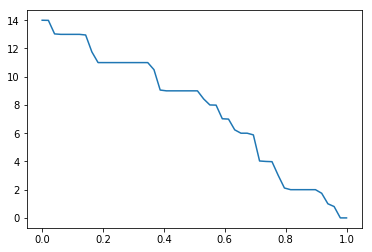

In [12]:
import numpy as np
P=np.load('transfer0.npy').mean(axis=2)
from scipy.stats import rankdata
priors={}
for i in range(14):
    priors[i]=15-rankdata(P[i], method='min')
current=2
#priors={2:[[2,3,1],[2,1,2]]}
B=list(np.random.random([14,14]))
#tt=[priors[current][i][1] for i in range(len(priors[current]))]
#r=[priors[current][i][2] for i in range(len(priors[current]))]
import torch
points=B[current]#[B[current][i] for i in tt]#[0.1,0.3,0.5,0.2]
def pss(x,points):
    def pss0(x,i):
        return torch.tanh(200*torch.tensor(x-i))/2+0.5
    return len(points)-sum([pss0(x,i) for i in points])
import matplotlib.pyplot as plt
x=torch.linspace(0,1,50)
y=[pss(torch.tensor(i),points) for i in torch.linspace(0,1,50)]
plt.plot(x,y)
y=[pss(torch.tensor(i-0.05),points) for i in points]
torch.norm(torch.tensor(priors[current])-torch.tensor([pss(torch.tensor(i-0.05),points) for i in points])),y

In [13]:
w=[]
keys=['actor.0.weight', 'actor.0.bias', 'actor.2.weight', 'actor.2.bias']
for i in keys:
    w.append(torch.cat([algo[j].acmodel.state_dict()[i].unsqueeze(0) for j in range(len(envs0))]))
def l(currindex,t,w,B,mu=0.05,lamb=[0.05,0.01],U=[13],pi=list(range(14))):
    return lamb[0]*sum([sum([sum([torch.norm(w[i][s]-sum([B[pi[j]][s]*w[i][pi[j]] for j in range(currindex-1)])-B[t][s]*w[i][t],p=2)**2]) for s in set(U)-set([t])]) for i in range(len(keys))])+lamb[1]*torch.norm(torch.tensor(priors[current])-torch.tensor([pss(torch.tensor(i-0.05),points) for i in points]))**2
def r(t,rloss,B,mu=0.05):
    return mu*rloss[t]*torch.norm(torch.tensor(B[t]),p=1)
def f(currindex,t,w,B,rloss,mu=0.05,lamb=[0.05,0.01],U=[13],pi=list(range(14))):
    return r(t,rloss,B,mu)+l(currindex,t,w,B,mu,lamb,U,pi)
def prox(lamb,v):
    #lamb*torch.norm(x,p=1)+1/2*torch.norm(x-v,p=2)
    return torch.sign(v)*torch.clip(torch.abs(v)-lamb,0)
def FISTA(y,X,lamb=1):
    #1/2(y-Xw)+lamb*norm(w,p=1)
    tk=1
    w=[torch.tensor(np.random.random(14)/2)]*2
    cnt=0
    while cnt<1000:
        yk=w[-1]+(tk-1)/tk*(w[-1]-w[-2])
        yk2=torch.tensor(yk,requires_grad=True)
        func=lambda v:1/2*torch.norm(y-X.mm(v.float().view([len(yk),1])))**2
        target=func(yk2)
        target.backward()
        tmp=prox(lamb/tk,w[-1]-tk*yk2.grad)
        w=[tmp,w[-1]]
        tk=(1+np.sqrt(1+4*tk**2))/2
        cnt+=1
        if torch.norm(w[-1]-w[-2])<1e-3:
            break
    return w[-1]

In [41]:
rloss=torch.tensor([1]*14)
currindex,t=0,1
eta=1.2
tmin=0.001
tmax=200
tk=0.01
k=0
mu=0.05
rnd=200
sigma=1
variable=torch.tensor(np.random.random(14)/2)
tk=np.clip(tk,tmin,tmax)
for _ in range(100):
    print('------')
    for cnt in range(rnd):
        B[t]=torch.tensor(list(B[t]),requires_grad=True)
        ltarget=l(currindex,t,w,B)
        ltarget.backward()
        new_variable=FISTA(B[t]-B[t].grad/tk,torch.ones([14,14]),mu*rloss[t]/tk)
        B2=B.copy()
        B2[t]=new_variable
        print(f(currindex,t,w,B2,rloss))
        if f(currindex,t,w,B2,rloss)-f(currindex,t,w,B,rloss)+sigma/2*tk*torch.norm(new_variable-B[t])**2<=1e-3:
            break
        elif cnt<rnd-1:
            print(cnt)
            B[t]=B[t].detach()
            B[t].copy_(new_variable)
        tk=eta*tk
    B[t]=torch.tensor(list(B[t]),requires_grad=True)
    ltarget=l(currindex,t,w,B)
    ltarget.backward()
    y1=B[t].grad
    B[t]=B[t].detach()
    B2=B.copy()
    B2[t]=torch.tensor(new_variable,requires_grad=True)
    ltarget=l(currindex,t,w,B2)
    ltarget.backward()
    y2=B2[t].grad
    tk=(B[t]-new_variable).dot(y1-y2)/(torch.norm(new_variable-B[t])**2)

------


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

tensor(7.6688, device='cuda:0', dtype=torch.float64)
------
tensor(8.6323, device='cuda:0', dtype=torch.float64)
0
tensor(8.2957, device='cuda:0', dtype=torch.float64)
------
tensor(7.6735, device='cuda:0', dtype=torch.float64)
------
tensor(7.8131, device='cuda:0', dtype=torch.float64)
0
tensor(8.5487, device='cuda:0', dtype=torch.float64)
1
tensor(8.3040, device='cuda:0', dtype=torch.float64)
2
tensor(7.8234, device='cuda:0', dtype=torch.float64)
3
tensor(7.6493, device='cuda:0', dtype=torch.float64)
4
tensor(8.0817, device='cuda:0', dtype=torch.float64)
5
tensor(8.5369, device='cuda:0', dtype=torch.float64)
6
tensor(7.5985, device='cuda:0', dtype=torch.float64)
7
tensor(8.0344, device='cuda:0', dtype=torch.float64)
8
tensor(8.1431, device='cuda:0', dtype=torch.float64)
9
tensor(8.3496, device='cuda:0', dtype=torch.float64)
10
tensor(7.6698, device='cuda:0', dtype=torch.float64)
11
tensor(7.6933, device='cuda:0', dtype=torch.float64)
12
tensor(7.6447, device='cuda:0', dtype=torch.flo

tensor(8.4104, device='cuda:0', dtype=torch.float64)
142
tensor(8.5354, device='cuda:0', dtype=torch.float64)
143
tensor(8.0020, device='cuda:0', dtype=torch.float64)
144
tensor(7.6411, device='cuda:0', dtype=torch.float64)
145
tensor(7.6349, device='cuda:0', dtype=torch.float64)
146
tensor(7.7772, device='cuda:0', dtype=torch.float64)
147
tensor(7.7311, device='cuda:0', dtype=torch.float64)
148
tensor(7.6498, device='cuda:0', dtype=torch.float64)
149
tensor(7.6365, device='cuda:0', dtype=torch.float64)
150
tensor(7.9332, device='cuda:0', dtype=torch.float64)
151
tensor(7.7694, device='cuda:0', dtype=torch.float64)
152
tensor(7.7378, device='cuda:0', dtype=torch.float64)
153
tensor(7.6539, device='cuda:0', dtype=torch.float64)
154
tensor(7.7072, device='cuda:0', dtype=torch.float64)
155
tensor(7.5767, device='cuda:0', dtype=torch.float64)
156
tensor(8.5287, device='cuda:0', dtype=torch.float64)
157
tensor(7.8031, device='cuda:0', dtype=torch.float64)
158
tensor(8.6061, device='cuda:0',

tensor(7.6517, device='cuda:0', dtype=torch.float64)
72
tensor(8.4989, device='cuda:0', dtype=torch.float64)
73
tensor(7.8700, device='cuda:0', dtype=torch.float64)
74
tensor(8.4834, device='cuda:0', dtype=torch.float64)
75
tensor(7.6856, device='cuda:0', dtype=torch.float64)
76
tensor(8.1261, device='cuda:0', dtype=torch.float64)
77
tensor(7.8467, device='cuda:0', dtype=torch.float64)
78
tensor(8.2798, device='cuda:0', dtype=torch.float64)
79
tensor(7.7203, device='cuda:0', dtype=torch.float64)
80
tensor(7.8396, device='cuda:0', dtype=torch.float64)
81
tensor(7.6691, device='cuda:0', dtype=torch.float64)
82
tensor(8.5217, device='cuda:0', dtype=torch.float64)
83
tensor(7.6474, device='cuda:0', dtype=torch.float64)
84
tensor(8.1745, device='cuda:0', dtype=torch.float64)
85
tensor(7.6880, device='cuda:0', dtype=torch.float64)
86
tensor(7.6568, device='cuda:0', dtype=torch.float64)
87
tensor(8.5874, device='cuda:0', dtype=torch.float64)
88
tensor(8.2993, device='cuda:0', dtype=torch.floa

tensor(8.1406, device='cuda:0', dtype=torch.float64)
8
tensor(7.6298, device='cuda:0', dtype=torch.float64)
9
tensor(7.8388, device='cuda:0', dtype=torch.float64)
10
tensor(8.1278, device='cuda:0', dtype=torch.float64)
11
tensor(8.0274, device='cuda:0', dtype=torch.float64)
12
tensor(7.6464, device='cuda:0', dtype=torch.float64)
13
tensor(7.6701, device='cuda:0', dtype=torch.float64)
14
tensor(8.0230, device='cuda:0', dtype=torch.float64)
15
tensor(7.6079, device='cuda:0', dtype=torch.float64)
16
tensor(8.2985, device='cuda:0', dtype=torch.float64)
17
tensor(7.9673, device='cuda:0', dtype=torch.float64)
18
tensor(8.1137, device='cuda:0', dtype=torch.float64)
19
tensor(7.8281, device='cuda:0', dtype=torch.float64)
20
tensor(8.1886, device='cuda:0', dtype=torch.float64)
21
tensor(7.6460, device='cuda:0', dtype=torch.float64)
22
tensor(7.7150, device='cuda:0', dtype=torch.float64)
23
tensor(8.2871, device='cuda:0', dtype=torch.float64)
24
tensor(8.2242, device='cuda:0', dtype=torch.float6

tensor(8.0351, device='cuda:0', dtype=torch.float64)
154
tensor(8.3748, device='cuda:0', dtype=torch.float64)
155
tensor(7.6105, device='cuda:0', dtype=torch.float64)
156
tensor(7.7419, device='cuda:0', dtype=torch.float64)
157
tensor(8.5533, device='cuda:0', dtype=torch.float64)
158
tensor(7.7054, device='cuda:0', dtype=torch.float64)
159
tensor(8.0927, device='cuda:0', dtype=torch.float64)
160
tensor(7.6572, device='cuda:0', dtype=torch.float64)
161
tensor(7.6854, device='cuda:0', dtype=torch.float64)
162
tensor(7.8878, device='cuda:0', dtype=torch.float64)
163
tensor(7.6520, device='cuda:0', dtype=torch.float64)
164
tensor(7.6756, device='cuda:0', dtype=torch.float64)
165
tensor(7.8813, device='cuda:0', dtype=torch.float64)
166
tensor(7.6857, device='cuda:0', dtype=torch.float64)
167
tensor(7.9006, device='cuda:0', dtype=torch.float64)
168
tensor(7.9129, device='cuda:0', dtype=torch.float64)
169
tensor(7.7617, device='cuda:0', dtype=torch.float64)
170
tensor(7.6403, device='cuda:0',

tensor(8.0188, device='cuda:0', dtype=torch.float64)
95
tensor(7.9001, device='cuda:0', dtype=torch.float64)
96
tensor(7.7571, device='cuda:0', dtype=torch.float64)
97
tensor(8.0629, device='cuda:0', dtype=torch.float64)
98
tensor(8.1461, device='cuda:0', dtype=torch.float64)
99
tensor(8.4136, device='cuda:0', dtype=torch.float64)
100
tensor(8.2875, device='cuda:0', dtype=torch.float64)
101
tensor(8.5010, device='cuda:0', dtype=torch.float64)
102
tensor(7.7075, device='cuda:0', dtype=torch.float64)
103
tensor(8.3254, device='cuda:0', dtype=torch.float64)
104
tensor(7.7973, device='cuda:0', dtype=torch.float64)
105
tensor(8.0399, device='cuda:0', dtype=torch.float64)
106
tensor(7.6587, device='cuda:0', dtype=torch.float64)
107
tensor(7.7738, device='cuda:0', dtype=torch.float64)
108
tensor(8.3329, device='cuda:0', dtype=torch.float64)
109
tensor(8.0645, device='cuda:0', dtype=torch.float64)
110
tensor(7.9891, device='cuda:0', dtype=torch.float64)
111
tensor(7.9280, device='cuda:0', dtyp

tensor(7.8346, device='cuda:0', dtype=torch.float64)
29
tensor(8.2206, device='cuda:0', dtype=torch.float64)
30
tensor(7.6578, device='cuda:0', dtype=torch.float64)
31
tensor(8.0472, device='cuda:0', dtype=torch.float64)
32
tensor(7.6886, device='cuda:0', dtype=torch.float64)
33
tensor(8.2124, device='cuda:0', dtype=torch.float64)
34
tensor(7.5823, device='cuda:0', dtype=torch.float64)
35
tensor(8.2457, device='cuda:0', dtype=torch.float64)
36
tensor(7.6670, device='cuda:0', dtype=torch.float64)
37
tensor(7.9668, device='cuda:0', dtype=torch.float64)
38
tensor(7.6042, device='cuda:0', dtype=torch.float64)
39
tensor(8.3927, device='cuda:0', dtype=torch.float64)
40
tensor(8.3658, device='cuda:0', dtype=torch.float64)
41
tensor(8.0917, device='cuda:0', dtype=torch.float64)
42
tensor(8.2958, device='cuda:0', dtype=torch.float64)
43
tensor(7.6626, device='cuda:0', dtype=torch.float64)
44
tensor(8.5333, device='cuda:0', dtype=torch.float64)
45
tensor(7.6787, device='cuda:0', dtype=torch.floa

tensor(8.1489, device='cuda:0', dtype=torch.float64)
174
tensor(7.6781, device='cuda:0', dtype=torch.float64)
175
tensor(8.1063, device='cuda:0', dtype=torch.float64)
176
tensor(8.5486, device='cuda:0', dtype=torch.float64)
177
tensor(7.6606, device='cuda:0', dtype=torch.float64)
178
tensor(7.9652, device='cuda:0', dtype=torch.float64)
179
tensor(8.2260, device='cuda:0', dtype=torch.float64)
180
tensor(7.9054, device='cuda:0', dtype=torch.float64)
181
tensor(8.4175, device='cuda:0', dtype=torch.float64)
182
tensor(8.0782, device='cuda:0', dtype=torch.float64)
183
tensor(8.3384, device='cuda:0', dtype=torch.float64)
184
tensor(8.5239, device='cuda:0', dtype=torch.float64)
185
tensor(8.1439, device='cuda:0', dtype=torch.float64)
186
tensor(8.0900, device='cuda:0', dtype=torch.float64)
187
tensor(7.7670, device='cuda:0', dtype=torch.float64)
188
tensor(7.9702, device='cuda:0', dtype=torch.float64)
189
tensor(7.5974, device='cuda:0', dtype=torch.float64)
190
tensor(8.6040, device='cuda:0',

tensor(7.6324, device='cuda:0', dtype=torch.float64)
103
tensor(7.5969, device='cuda:0', dtype=torch.float64)
104
tensor(7.6900, device='cuda:0', dtype=torch.float64)
105
tensor(7.6741, device='cuda:0', dtype=torch.float64)
106
tensor(8.4067, device='cuda:0', dtype=torch.float64)
107
tensor(7.6480, device='cuda:0', dtype=torch.float64)
108
tensor(8.3581, device='cuda:0', dtype=torch.float64)
109
tensor(7.7326, device='cuda:0', dtype=torch.float64)
110
tensor(8.1148, device='cuda:0', dtype=torch.float64)
111
tensor(8.2069, device='cuda:0', dtype=torch.float64)
112
tensor(8.5243, device='cuda:0', dtype=torch.float64)
113
tensor(7.6077, device='cuda:0', dtype=torch.float64)
114
tensor(7.7345, device='cuda:0', dtype=torch.float64)
115
tensor(7.6825, device='cuda:0', dtype=torch.float64)
116
tensor(7.5968, device='cuda:0', dtype=torch.float64)
117
tensor(8.4305, device='cuda:0', dtype=torch.float64)
118
tensor(8.1749, device='cuda:0', dtype=torch.float64)
119
tensor(7.6547, device='cuda:0',

tensor(7.8792, device='cuda:0', dtype=torch.float64)
38
tensor(8.0095, device='cuda:0', dtype=torch.float64)
39
tensor(7.7468, device='cuda:0', dtype=torch.float64)
40
tensor(7.6959, device='cuda:0', dtype=torch.float64)
41
tensor(8.1833, device='cuda:0', dtype=torch.float64)
42
tensor(7.6458, device='cuda:0', dtype=torch.float64)
43
tensor(7.6357, device='cuda:0', dtype=torch.float64)
44
tensor(8.5660, device='cuda:0', dtype=torch.float64)
45
tensor(7.9502, device='cuda:0', dtype=torch.float64)
46
tensor(8.0296, device='cuda:0', dtype=torch.float64)
47
tensor(8.1618, device='cuda:0', dtype=torch.float64)
48
tensor(8.3903, device='cuda:0', dtype=torch.float64)
49
tensor(8.0838, device='cuda:0', dtype=torch.float64)
50
tensor(8.0220, device='cuda:0', dtype=torch.float64)
51
tensor(8.4195, device='cuda:0', dtype=torch.float64)
52
tensor(7.6984, device='cuda:0', dtype=torch.float64)
53
tensor(8.6013, device='cuda:0', dtype=torch.float64)
54
tensor(7.6602, device='cuda:0', dtype=torch.floa

tensor(7.6619, device='cuda:0', dtype=torch.float64)
183
tensor(8.2848, device='cuda:0', dtype=torch.float64)
184
tensor(7.7642, device='cuda:0', dtype=torch.float64)
185
tensor(8.1645, device='cuda:0', dtype=torch.float64)
186
tensor(7.5966, device='cuda:0', dtype=torch.float64)
187
tensor(7.8601, device='cuda:0', dtype=torch.float64)
188
tensor(7.6669, device='cuda:0', dtype=torch.float64)
189
tensor(8.4702, device='cuda:0', dtype=torch.float64)
190
tensor(7.7083, device='cuda:0', dtype=torch.float64)
191
tensor(8.4075, device='cuda:0', dtype=torch.float64)
192
tensor(7.6722, device='cuda:0', dtype=torch.float64)
193
tensor(7.7933, device='cuda:0', dtype=torch.float64)
194
tensor(8.0018, device='cuda:0', dtype=torch.float64)
195
tensor(7.7604, device='cuda:0', dtype=torch.float64)
196
tensor(8.1753, device='cuda:0', dtype=torch.float64)
197
tensor(8.2213, device='cuda:0', dtype=torch.float64)
198
tensor(7.6777, device='cuda:0', dtype=torch.float64)
------
tensor(7.6563, device='cuda:

tensor(8.0736, device='cuda:0', dtype=torch.float64)
121
tensor(8.5466, device='cuda:0', dtype=torch.float64)
122
tensor(7.7023, device='cuda:0', dtype=torch.float64)
123
tensor(7.6877, device='cuda:0', dtype=torch.float64)
124
tensor(8.0464, device='cuda:0', dtype=torch.float64)
125
tensor(7.6943, device='cuda:0', dtype=torch.float64)
126
tensor(7.7192, device='cuda:0', dtype=torch.float64)
127
tensor(8.4081, device='cuda:0', dtype=torch.float64)
128
tensor(8.4494, device='cuda:0', dtype=torch.float64)
129
tensor(7.8992, device='cuda:0', dtype=torch.float64)
130
tensor(8.0843, device='cuda:0', dtype=torch.float64)
131
tensor(7.7046, device='cuda:0', dtype=torch.float64)
132
tensor(7.6361, device='cuda:0', dtype=torch.float64)
133
tensor(8.1770, device='cuda:0', dtype=torch.float64)
134
tensor(8.1106, device='cuda:0', dtype=torch.float64)
135
tensor(7.6865, device='cuda:0', dtype=torch.float64)
136
tensor(7.6516, device='cuda:0', dtype=torch.float64)
137
tensor(7.7172, device='cuda:0',

tensor(7.6517, device='cuda:0', dtype=torch.float64)
53
tensor(8.2110, device='cuda:0', dtype=torch.float64)
54
tensor(7.9991, device='cuda:0', dtype=torch.float64)
55
tensor(7.6869, device='cuda:0', dtype=torch.float64)
56
tensor(7.7987, device='cuda:0', dtype=torch.float64)
57
tensor(8.0099, device='cuda:0', dtype=torch.float64)
58
tensor(7.9522, device='cuda:0', dtype=torch.float64)
59
tensor(7.9143, device='cuda:0', dtype=torch.float64)
60
tensor(7.6381, device='cuda:0', dtype=torch.float64)
61
tensor(8.5550, device='cuda:0', dtype=torch.float64)
62
tensor(7.6720, device='cuda:0', dtype=torch.float64)
63
tensor(7.7050, device='cuda:0', dtype=torch.float64)
64
tensor(7.6146, device='cuda:0', dtype=torch.float64)
65
tensor(7.7738, device='cuda:0', dtype=torch.float64)
66
tensor(7.8079, device='cuda:0', dtype=torch.float64)
67
tensor(8.2362, device='cuda:0', dtype=torch.float64)
68
tensor(8.0763, device='cuda:0', dtype=torch.float64)
69
tensor(7.9259, device='cuda:0', dtype=torch.floa

tensor(8.5232, device='cuda:0', dtype=torch.float64)
198
tensor(8.2544, device='cuda:0', dtype=torch.float64)
------
tensor(8.0701, device='cuda:0', dtype=torch.float64)
------
tensor(8.2893, device='cuda:0', dtype=torch.float64)
------
tensor(7.8454, device='cuda:0', dtype=torch.float64)
------
tensor(8.1070, device='cuda:0', dtype=torch.float64)
------
tensor(7.9826, device='cuda:0', dtype=torch.float64)
------
tensor(7.6371, device='cuda:0', dtype=torch.float64)
------
tensor(7.7091, device='cuda:0', dtype=torch.float64)
------
tensor(8.1297, device='cuda:0', dtype=torch.float64)
0
tensor(8.4091, device='cuda:0', dtype=torch.float64)
1
tensor(7.6695, device='cuda:0', dtype=torch.float64)
------
tensor(8.5097, device='cuda:0', dtype=torch.float64)
0
tensor(8.1127, device='cuda:0', dtype=torch.float64)
1
tensor(8.0692, device='cuda:0', dtype=torch.float64)
2
tensor(7.6065, device='cuda:0', dtype=torch.float64)
3
tensor(8.0068, device='cuda:0', dtype=torch.float64)
4
tensor(7.6587, dev

KeyboardInterrupt: 

In [54]:
sys.path.insert(0,'/root/server/Semantic-Loss/complex_constraints/constopt-pytorch/')
import constopt
from constopt.constraints import LinfBall
from constopt.stochastic import PGD, PGDMadry, FrankWolfe, MomentumFrankWolfe

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


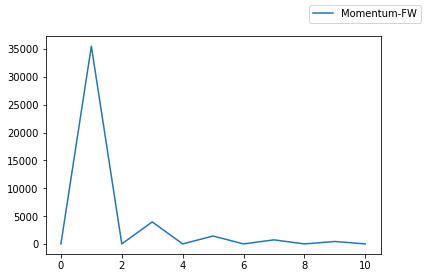

In [79]:
torch.random.manual_seed(0)

OPTIMIZER_CLASSES = [PGD, PGDMadry, FrankWolfe, MomentumFrankWolfe]


def setup_problem(make_nonconvex=False):
    radius = 100.
    x_0 = B[t]#torch.zeros_like(B[t])+0.02
    loss_func=f
    constraint = LinfBall(radius)

    return x_0, loss_func, constraint


def optimize(x_0, loss_func, constraint, optimizer_class, iterations=10):
    x = B[t]
    x.requires_grad = True
    optimizer = optimizer_class([x], constraint)
    iterates = [x.data.numpy().copy()]
    losses = []
    # Use Madry's heuristic for step size
    step_size = {
        FrankWolfe.name: None,
        MomentumFrankWolfe.name: None,
        PGD.name: 2.5 * constraint.alpha / iterations * 2.,
        PGDMadry.name: 2.5 * constraint.alpha / iterations
    }

    for _ in range(iterations):
        optimizer.zero_grad()
        loss = loss_func(currindex,t,w,B,rloss)
        loss.backward()
        optimizer.step(step_size[optimizer.name])
        losses.append(loss.item())
        iterates.append(x.data.numpy().copy())
    B[t]=x.detach()
    loss = loss_func(currindex,t,w,B,rloss)
    losses.append(loss.item())
    return losses, iterates

x_0, loss_func, constraint = setup_problem(make_nonconvex=False)
iterations = 10
losses_all = {}
iterates_all = {}
for opt_class in OPTIMIZER_CLASSES:
    losses_, iterates_ = optimize(x_0,
                                  loss_func,
                                  constraint,
                                  opt_class,
                                  iterations)
    losses_all[opt_class.name] = losses_
    iterates_all[opt_class.name] = iterates_
# print(losses)
fig, ax = plt.subplots()
for opt_class in OPTIMIZER_CLASSES:
    ax.plot(np.arange(iterations + 1), losses_all[opt_class.name],
            label=opt_class.name)
fig.legend()

In [75]:
losses_all

{'PGD': [7.454983373762332,
  147.42359217877043,
  35525.04170224595,
  35499.87763974595,
  35525.04170224595,
  35499.87763974595,
  35525.04170224595,
  35499.87763974595,
  35525.04170224595,
  35499.87763974595,
  35525.04170224595],
 'PGD-Madry': [35525.04170224595,
  35499.87763974595,
  35525.04170224595,
  35499.87763974595,
  35525.04170224595,
  35499.87763974595,
  35525.04170224595,
  35499.87763974595,
  35525.04170224595,
  35499.87763974595,
  35525.04170224595],
 'Vanilla-FW': [35525.04170224595,
  3949.372431362948,
  3957.759150112948,
  1425.9391631238473,
  1430.9711455457223,
  730.8619449276254,
  734.4561832088754,
  444.88436711028004,
  447.6798383016863,
  300.1543592050304,
  302.4415906503429],
 'Momentum-FW': [302.4415906503429,
  35499.87763974595,
  7.454983373762332,
  3957.759150112948,
  7.454983373762332,
  1425.9391631238473,
  7.454983373762332,
  734.4561832088754,
  7.454983373762332,
  444.88436711028004,
  7.454983373762332]}

In [78]:
iterates_all

{'PGD': [array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.77635684e-15]),
  array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        , -6.28983863]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0., 100.]),
  array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0., -100.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0., 100.]),
  array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0., -100.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
 

In [63]:
B[t]=torch.tensor(B[t]-0.1,requires_grad=True)
optimizer=torch.optim.RMSprop([B[t]],lr=1e-3)
for step in range(500):
    #B[t]=torch.clip(B[t],0,100)
    pre=f(currindex,t,w,B,rloss)
    print(pre)
    optimizer.zero_grad()
    pre.backward(retain_graph=True)
    optimizer.step()
    with torch.no_grad():
        B[t].clamp_(0, 100)
B[t]=B[t].detach()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


tensor(7.5538, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.5021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

KeyboardInterrupt: 

In [33]:
import torch_optimizer as optim
B[t]=torch.tensor(B[t],requires_grad=True)
yogi = optim.Yogi(
    [B[t]],
    lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0,
)

optimizer = optim.Lookahead(yogi, k=5, alpha=0.5)
optimizer.step()
for step in range(500):
    #B[t]=torch.clip(B[t],0,100)
    pre=f(currindex,t,w,B,rloss)
    print(pre)
    optimizer.zero_grad()
    pre.backward(retain_graph=True)
    optimizer.step()
B[t]=B[t].detach()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


tensor(8.2218, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.1941, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.1671, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.1408, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.1154, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.1540, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.1282, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.1032, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.0789, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.0554, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.0912, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.0674, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.0444, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(7.6714, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6708, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6717, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6711, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6706, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6701, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6696, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6704, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6699, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6695, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6691, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6688, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6694, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6680, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

In [30]:
B[t]=B[t].detach()

In [63]:
new_variable.copy_(B[t])

tensor([0.4959, 0.0357, 0.4372, 0.1950, 0.4298, 0.1561, 0.0733, 0.0204, 0.4945,
        0.1767, 0.3516, 0.0071, 0.3858, 0.1154], dtype=torch.float64,
       grad_fn=<CopyBackwards>)

In [64]:
new_variable.copy_(B[t]*2)
new_variable

tensor([0.9919, 0.0714, 0.8745, 0.3900, 0.8596, 0.3123, 0.1465, 0.0408, 0.9890,
        0.3533, 0.7032, 0.0141, 0.7716, 0.2308], dtype=torch.float64,
       grad_fn=<CopyBackwards>)